In [1]:
import matplotlib.pyplot as plt
import emcee
import numpy as np
import batman
import scipy.stats as stats
import pickle
from multiprocessing import Pool
import pygtc
import corner
from MCMC_Class import MCMC

%matplotlib widget

In [2]:
#theta
#0: t0
#1: period
#2: planet radius
#3: a
#4: i
#5: u1
#6: u2
#7: 0th order coeff
#8: 1st " "
#9: 2nd " "
#10: jitter

In [3]:
theta_taste = np.empty(11)

theta_taste[0] = 2459990.6371415    #by eye
theta_taste[1] = 3.2130573
theta_taste[2] = 0.1406
theta_taste[3] = 11.77
theta_taste[4] = 89
theta_taste[5] = 0.6367
theta_taste[6] = 0.1300
theta_taste[7] = 0.6615
theta_taste[8] = 0.0
theta_taste[9] = 0.0
theta_taste[10] = 0.0

In [4]:
taste_dictionary = pickle.load((open('../Results/TASTE/diff_dictionary.p', 'rb')))
bjd_taste = taste_dictionary['time']
flux_taste = pickle.load((open('../Results/TASTE/differential_allref.p', 'rb')))
flux_error_taste = pickle.load((open('../Results/TASTE/differential_allref_err.p', 'rb')))

def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]         #from ExoFOP                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    median_bjd = np.median(bjd_taste)
    polynomial_trend = theta[7] + theta[8]*(bjd_taste-median_bjd) + theta[9]*(bjd_taste-median_bjd)**2

    m_taste = batman.TransitModel(params, bjd_taste)
    taste_model = m_taste.light_curve(params) * polynomial_trend
    
    taste_errors_with_jitter = flux_error_taste**2 + theta[10]**2

    N = len(taste_errors_with_jitter)

    chi2_taste = np.sum( (flux_taste - taste_model)**2 / taste_errors_with_jitter)
    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_taste  + sum_ln_sigma_taste)
    return log_likelihood

In [5]:
def log_prior(theta):
    prior = 0.00
    prior+= np.log(stats.norm.pdf(theta[1], loc=3.2130573, scale=0.0000008))
    prior+= np.log(stats.norm.pdf(theta[5], loc=0.6367, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[6], loc=0.1300, scale=0.10))
    return prior

boundaries = np.empty([2, len(theta_taste)])

boundaries[:,0] = [bjd_taste[0]-0.5, bjd_taste[-1]+0.5]
boundaries[:,1] = [theta_taste[1]-0.5, theta_taste[1]+0.5]
boundaries[:,2] = [0.0, 0.5]
boundaries[:,3] = [0.0, 20.0]
boundaries[:,4] = [80.0, 90.0]
boundaries[:,5] = [0.00, 1.0]
boundaries[:,6] = [0.00, 1.0]
boundaries[:,7] = [0.00, 1.0]
boundaries[:,8] = [-1.0, 1.0]
boundaries[:,9] = [-1.0, 1.0]
boundaries[:,10] = [0.0, 0.05]

def log_posterior(theta):
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_prob = log_prior(theta)

    log_prob += log_likelihood(theta)
    return log_prob

In [6]:
#Run the MCMC

nwalkers = 50
nsteps = 20000
ndim = len(theta_taste)
starting_point = theta_taste + np.abs(1e-5 * np.random.randn(nwalkers, ndim))

In [7]:
with Pool() as pool:
    taste_mcmc = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)
    taste_mcmc.run_mcmc(starting_point, nsteps, progress=True)

100%|██████████| 20000/20000 [03:20<00:00, 99.60it/s]


In [8]:
#taste_mcmc = pickle.load((open('../Results/MCMC/run_taste_v5.p', 'rb')))

Text(0.5, 0, 'step number')

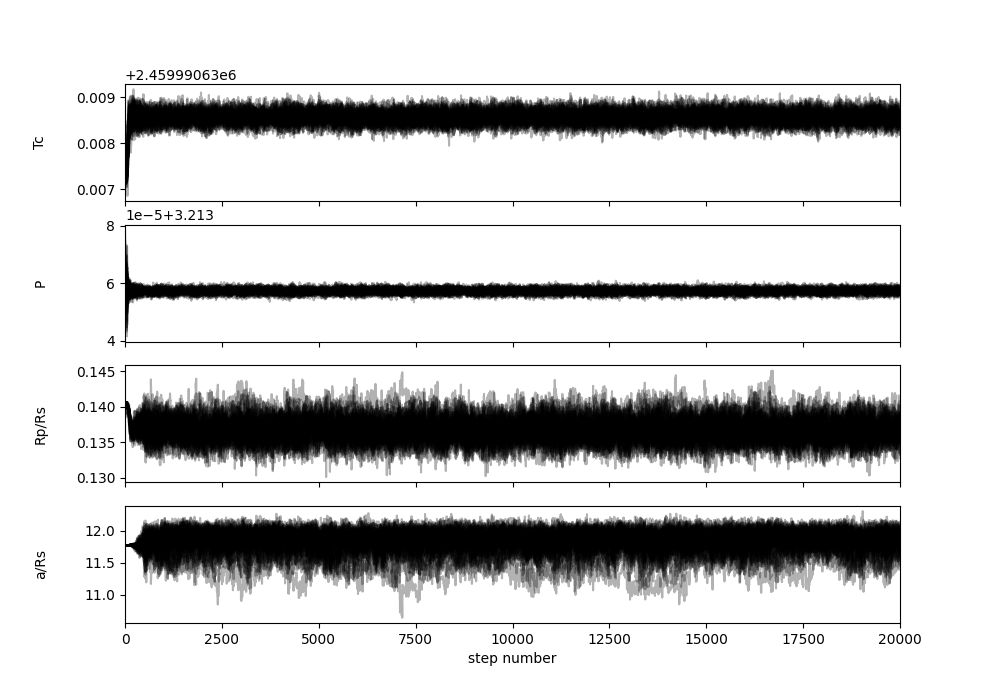

In [9]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = taste_mcmc.get_chain()
labels = ["Tc", "P", "Rp/Rs", "a/Rs"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [11]:
pickle.dump(taste_mcmc, open('../Results/MCMC/TASTE/run_taste_v6.p', 'wb'))

In [12]:
#check if the chain converged before the going to the next step

taste = pickle.load((open('../Results/MCMC/TASTE/run_taste_v6.p', 'rb')))

flat_samples = taste.get_chain(discard=5000, thin=100, flat=True)
print(flat_samples.shape)

ndim = len(theta_taste)

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

(7500, 11)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

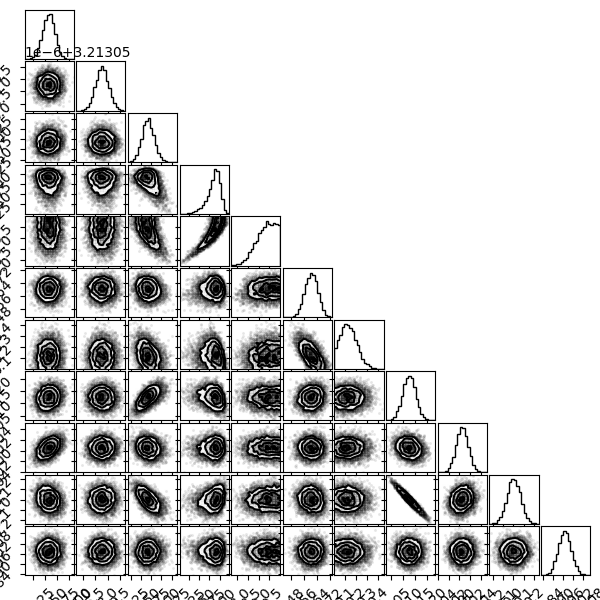

(7500, 11)


In [13]:
#GTC = pygtc.plotGTC(chains=samples)

flat_samples = taste.get_chain(discard=5000, thin=100, flat=True)

fig = plt.figure(figsize=(6, 6))
corner.corner(flat_samples, fig=fig)
plt.show()

print(np.shape(flat_samples))